In [1]:
# If the below code doesn't work uncomment this and run (this adds the parent directory to the path)
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np

dl = DataLib("SignalData")

#### `TODO`
- Take reciprocals of any currencies if stronger currency is listed first (i.e. standardize the fx format)

In [10]:
# Pull all the necessary dataframes to avoid duplicate code. 
BondRetIdx = dl.pull("BondRetIdx/LocalFX")
fx = dl.pull("fxVsUSD")

# Get the change period-to-period. 
fx_chg = fx.pct_change()

# For each country (column), get a rolling average for the past year. 
sma = fx_chg.rolling(4).mean()
std = fx_chg.rolling(4).std()

# Turn the change into a zscore. 
zscore = (fx_chg - sma) / std

We want to put every currency in terms of USD (i.e. USD-XXX = how much does 1 USD buy of XXX). 

In [20]:
# Currency convention: EUR, GBP, AUD, NZD, USD
fx.columns.values

array(['AUS', 'DEU', 'CAN', 'ESP', 'FRA', 'ITA', 'JPN', 'CHE', 'GBR',
       'USA'], dtype=object)

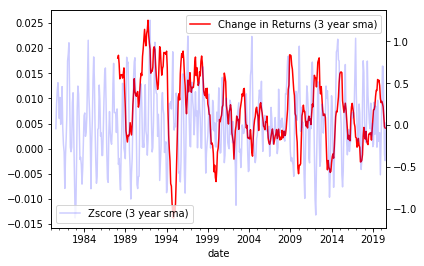

In [18]:
# Get bond returns. Resample to montly. 
bri = dl.pull('BondRetIdx/LocalFX')
bri_m = bri.resample('M').mean()
bri_m_chg = bri_m.pct_change()

# Plot bond returns alongside changes in fx. 
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
bri_m_chg['AUS'].rolling(12).mean().plot(ax=ax1, color='red', label='Change in Returns (3 year sma)')
zscore['AUS'].rolling(4).mean().plot(ax=ax2, color='blue', alpha=0.2, label="Zscore (3 year sma)")
ax1.legend(loc=1)
ax2.legend(loc=3)

In [19]:
correlation = bri_m_chg.corrwith(zscore, method='pearson', axis=0)
correlation

country
AUS    0.031984
DEU   -0.040266
CAN   -0.022033
ESP    0.018036
FRA    0.072679
ITA   -0.054547
JPN   -0.131188
CHE   -0.014065
GBR    0.067301
USA    0.041196
dtype: float64